### Lista de exercícios - exercício 4

**Aluno:** André F. Oliveira

O algoritmo foi escrito de forma a permitir que o usuário abra um arquivo txt ou csv que esteja presente no diretório atual para que as análises subsequentes possam ser feitas em seu conteúdo. Para isto,uma lista com todo o conteúdo do diretório é mostrado na tela e cabe ao usuário fornecer o nome do arquivo a ser aberto (incluindo a sua extensão). Após isso, a quantidade e o nome de cada um dos sinais é mostrado na tela. Isto, obviamente, depende da formatação do arquivo de dados, ou seja, se suas colunas contém ou não os nomes dos sinais referentes àqueles dados. Este algoritmo foi escrito pressupondo-se que o arquivo de dados contém um cabeçalho indicando o nome do sinal.

Uma vez escolhido o sinal, o algoritmo plota a localização da sua distribuição no gráfico de Cullen-Frey, algumas medidas estatísticas como média, desvio padrão, assimetria e curtose, além do histograma do sinal. Vale ressaltar que o código do Cullen-Frey aqui utilizado foi traduzido diretamente do pacote ```descdist``` da linguagem R. Ao usuário é então dada a opção para que o algoritmo ajuste automaticamente uma distribuição ao histograma ou que este ajuste seja feito por uma gaussiana ou GEV à escolha do mesmo. Caso a opção automática seja escolhida, o programa realiza o ajuste das 12 distribuições mais comuns presentes no pacote ```stats``` do módulo ```scipy```, tendo como base a minimização da soma do erro do quadrado das diferenças. Estas distribuições são: ```invgauss, burr12, halfgennorm, genextreme, exponpow, expon, genpareto, invgamma, gilbrat, wald, genpareto, norm```. A melhor distribuição é então mostrada na tela junto aos seus parâmetros de ajuste e ao erro obtido.

Ao usuário é dada a opção de fazer a mesma análise para outro sinal do mesmo arquivo ou que outro arquivo do diretório seja aberto. O programa só se encerra quando o usuário escolhe não continuar com mais nenhuma análise. por se tratar de um código que necessita da interação do usuário para realizar suas tarefas, achei melhor incluir alguns blocos ```try```-```except``` para garantir que mesmo que o usuário forneça informações erradas, o programa não se encerre. Isto acontece apenas se o usuário fornecer o nome de um arquivo inexistente no diretório ou uma coluna inexistente no arquivo de dados, onde o python automaticamente irá gerar os erros ```FileNotFoundError``` e ```KeyError``` respectivamente. Um exemplo de execução é mostrado abaixo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
from cullen_frey import graph
import warnings
import time
import fitter

warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = True


def reader():
    """
    Lê os arquivos do diretório atual e os exibe na tela
    """
    archive = os.listdir()
    print('\nArquivos no diretório atual:')
    for file in archive:
        print(file)
    file = str(input('\nNome e a extensão do arquivo a ser aberto: ')).strip()

    loader(file)


def loader(file):
    """
    Abre o arquivo escolhido pelo usuário
    ==========================
    Inputs
    file: Arquivo com extensão csv ou txt escolhido pelo usuário
    """

    tmp = pd.read_csv(file, index_col=0)
    print(f'\nForam encontrados \033[1m{len(tmp.columns)}\033[0m sinais e \033[1m{len(tmp)}\033[0m entradas' 
          f' no arquivo \033[1m{file}\033[0m:\n')
    print('  |  '.join([str(j) for j in tmp.columns]))
    sinal = str(input('Digite o nome sinal como mostrado acima: ')).strip()
    df = tmp[sinal]

    cf_graph(file, df, sinal)


def auto_fit(df):
    """
    Ajusta uma pdf ao arquivo de dados de entrada
    ==========================
    Inputs
    df: Arquivo de dados para aplicação do ajuste de uma PDF
    
    Outpus
    name: Nome da melhor PDF
    params: Parâmetros de ajuste da melhor PDF
    error: Soma do quadrado das diferenças. Utilizado para determinar a melhor PDF
    
    """
    distributions = ['invgauss', 'burr12', 'halfgennorm', 'genextreme', 'exponpow', 'expon', 'genpareto', 'invgamma',
                     'gilbrat', 'wald', 'genpareto', 'norm']

    fitted_errors = {}
    fitted_params = {}
    for distribution in distributions:
        dist = eval('stats.' + distribution)
        y_, x_ = np.histogram(df, bins=10, density=True)
        # np.histogram retorna x com N+1 valores. É necessário então rearranjar seus elementos para N valores
        x = [(this + x_[i + 1]) / 2. for i, this in enumerate(x_[0:-1])]
        param = dist.fit(df)
        pdf_fitted = dist.pdf(x, *param)
        # erro soma do erro quadrático
        sq_error = np.sum((y_ - pdf_fitted) ** 2)
        fitted_params[distribution] = param[:]
        fitted_errors[distribution] = sq_error
    name = pd.DataFrame({'SSE': fitted_errors}).sort_values('SSE').iloc[0].name
    params = fitted_params[name]
    error = fitted_errors[name]

    return name, params, error


def cf_graph(file, df, sinal):
    """
    Plota o gráfico cullen-frey para o sinal escolhido
    ==========================
    Inputs
    file: Arquivo com extensão csv ou txt escolhido pelo usuário
    df: Arquivo de dados para plot do gráfico de Cullen-Frey
    sinal: Nome do sinal a ser plotado. O algoritmo assume que o arquivo de dados contém colunas com 
    cabeçalhos que indicam o nome do sinal. 
    """
    print(f'\n\nPlotando o gráfico de Cullen-Frey para o sinal \033[1m{sinal}\033[0m...')
    time.sleep(2)
    plot = graph(df, boot=100)

    # Plota o histograma para dar uma noção da distribuição
    print(f'\n\nPlotando o histograma do sinal \033[1m{sinal}\033[0m ...')
    time.sleep(2)
    df.hist(ec='k', color='royalblue')
    plt.ylabel('Contagem')
    plt.title(f'Distribuição do sinal')
    plt.show()

    while True:
        try:
            t = int(input('\n\nDeseja que o código encontre o melhor ajuste ou deseja ajustar '
                          'uma gaussiana ou GEV?(1- Ajuste automático | 2- Gaussiana ou GEV): '))
        except ValueError:
            print('\nDigite apenas 1 ou 2!')
        else:

            if t == 1:
                name, params, error = auto_fit(df)
                print(f'\nMelhor pdf: \033[1m{name}\033[0m \nParâmetros: {params}\nErro (SQD): {error}')

                x = np.linspace(min(df), max(df), 200)
                dist = eval('stats.' + name)

                plt.plot(x, dist.pdf(x, *params), c='red', label=name)
                df.hist(ec='k', color='royalblue', density=True)
                plt.ylabel('Contagem')
                plt.title(f'Distribuição do sinal')
                plt.legend()
                plt.show()
                break

            elif t == 2:
                try:
                    dist = int(input('\nQual PDF deseja ajustar no histograma acima?' 
                                     '(1- Para gaussiana| 2- Para GEV): '))
                except ValueError:
                    print('\nDigite apenas 1 ou 2 para ajustar uma PDF ao histograma!')
                    continue

                else:
                    x = np.linspace(min(df), max(df), 200)

                    if dist == 1:
                        fit = stats.norm.fit(df)
                        pdf = stats.norm.pdf(x, *fit)

                        print('\n==== Parâmetros do ajuste com a gaussiana ====')
                        print(f'Média: {fit[0]:.4f}')
                        print(f'Desvio padrão: {fit[1]:.4f}')
                        plt.plot(x, pdf, c='red', label='normal')
                        df.hist(ec='k', color='royalblue', density=True)
                        plt.ylabel('Contagem')
                        plt.title(f'Distribuição do sinal')
                        plt.legend()
                        plt.show()
                        break

                    elif dist == 2:
                        fit = stats.genextreme.fit(df)
                        pdf = stats.genextreme.pdf(x, *fit)

                        print('\n==== Parâmetros do ajuste com a GEV ====')
                        print(f'Forma (c): {fit[0]:.4f}')
                        print(f'Média: {fit[1]:.4f}')
                        print(f'Desvio padrão: {fit[2]:.4f}')
                        plt.plot(x, pdf, c='red', label='GEV')
                        df.hist(ec='k', color='royalblue', density=True)
                        plt.ylabel('Contagem')
                        plt.title(f'Distribuição do sinal')
                        plt.legend()
                        plt.show()
                        break

                    else:
                        print('\nDigite apenas 1 ou 2 para ajustar uma PDF ao histograma!')
                        continue
            else:
                print('\nDigite apenas 1 ou 2 para ajustar uma PDF ao histograma!')
                continue

    while True:
        try:
            cont1 = int(input('Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): '))
        except ValueError:
            print('Digite apenas 0 ou 1!')
        else:
            if cont1 == 1:
                loader(file)
                break
            elif cont1 == 0:
                try:
                    cont2 = int(input('Deseja abrir outro arquivo csv? (0- Não |1- Sim): '))
                except ValueError:
                    print('Digite apenas 0 ou 1!')
                else:
                    if cont2 == 1:
                        reader()
                        break
                    elif cont2 == 0:
                        break
                    else:
                        print('\nDigite 0 ou 1 apenas!')
            else:
                print('\nDigite 0 ou 1 apenas!')


Arquivos no diretório atual:
cullen_frey.py
exer4.ipynb
.ipynb_checkpoints
sinais_0.csv
n:8192_0.csv
__pycache__

Nome e a extensão do arquivo a ser aberto: n:8192_0.csv

Foram encontrados 10 sinais e 8192 entradas no arquivo n:8192_0.csv:

n:8192 iter:0  |  n:8192 iter:1  |  n:8192 iter:2  |  n:8192 iter:3  |  n:8192 iter:4  |  n:8192 iter:5  |  n:8192 iter:6  |  n:8192 iter:7  |  n:8192 iter:8  |  n:8192 iter:9
Digite o nome sinal como mostrado acima: n:8192 iter:0 


Plotando o gráfico de Cullen-Frey para o sinal n:8192 iter:0...


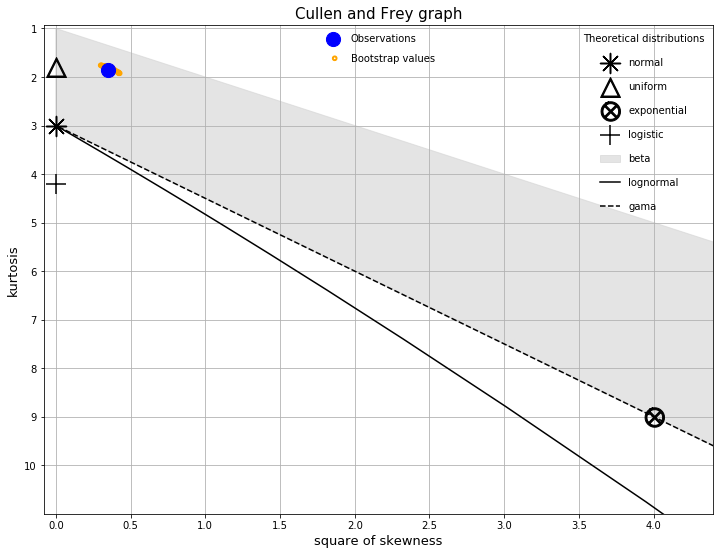

=== summary statistics ===
min:0.0000
max:1.0000
mean:0.3957
standard deviation:0.2713
skewness:0.5912
kurtosis:-1.1515


Plotando o histograma do sinal n:8192 iter:0 ...


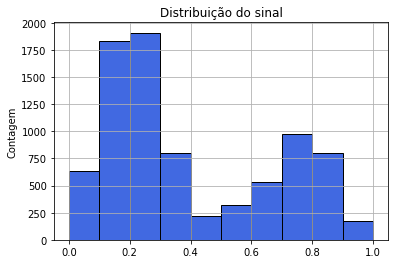



Deseja que o código encontre o melhor ajuste ou deseja ajustar uma gaussiana ou GEV?(1- Ajuste automático | 2- Gaussiana ou GEV): 1

Melhor pdf: wald 
Parâmetros: (-0.01916724479550754, 0.46412603362307875)
Erro (SQD): 2.372661761759728


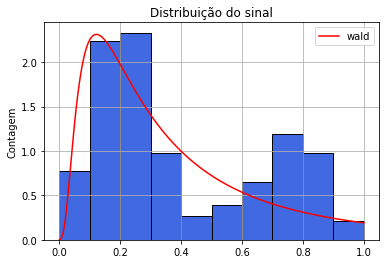

Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 1

Foram encontrados 10 sinais e 8192 entradas no arquivo n:8192_0.csv:

n:8192 iter:0  |  n:8192 iter:1  |  n:8192 iter:2  |  n:8192 iter:3  |  n:8192 iter:4  |  n:8192 iter:5  |  n:8192 iter:6  |  n:8192 iter:7  |  n:8192 iter:8  |  n:8192 iter:9
Digite o nome sinal como mostrado acima: n:8192 iter:8


Plotando o gráfico de Cullen-Frey para o sinal n:8192 iter:8...


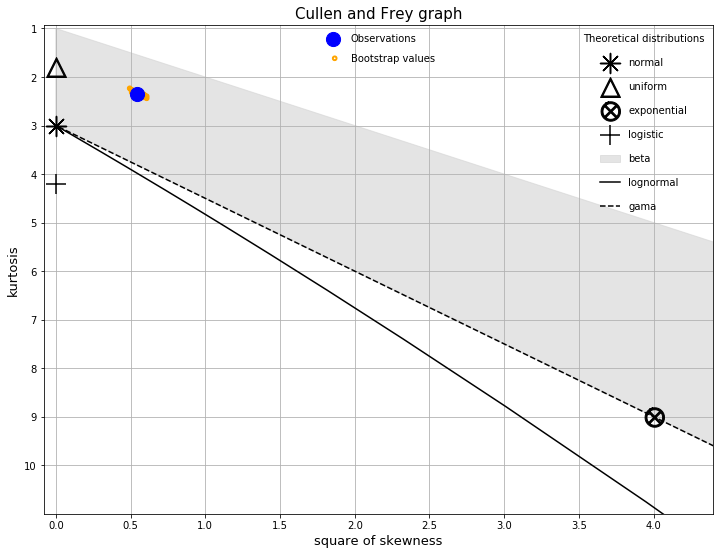

=== summary statistics ===
min:0.0000
max:1.0000
mean:0.5614
standard deviation:0.2555
skewness:-0.7353
kurtosis:-0.6449


Plotando o histograma do sinal n:8192 iter:8 ...


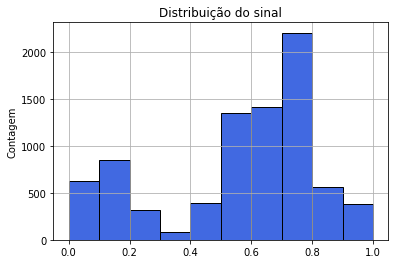



Deseja que o código encontre o melhor ajuste ou deseja ajustar uma gaussiana ou GEV?(1- Ajuste automático | 2- Gaussiana ou GEV): 1

Melhor pdf: exponpow 
Parâmetros: (5.7505300466486755, -0.9003670762470404, 1.6863369135045267)
Erro (SQD): 2.826691139649095


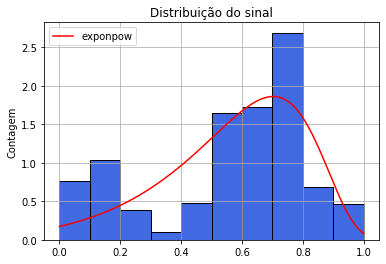

Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 0
Deseja abrir outro arquivo csv? (0- Não |1- Sim): 1

Arquivos no diretório atual:
cullen_frey.py
exer4.ipynb
.ipynb_checkpoints
sinais_0.csv
n:8192_0.csv
__pycache__

Nome e a extensão do arquivo a ser aberto: sinais_0.csv

Foram encontrados 60 sinais e 8192 entradas no arquivo sinais_0.csv:

beta:0 iter:0  |  beta:0 iter:1  |  beta:0 iter:2  |  beta:0 iter:3  |  beta:0 iter:4  |  beta:0 iter:5  |  beta:0 iter:6  |  beta:0 iter:7  |  beta:0 iter:8  |  beta:0 iter:9  |  beta:0 iter:10  |  beta:0 iter:11  |  beta:0 iter:12  |  beta:0 iter:13  |  beta:0 iter:14  |  beta:0 iter:15  |  beta:0 iter:16  |  beta:0 iter:17  |  beta:0 iter:18  |  beta:0 iter:19  |  beta:1 iter:0  |  beta:1 iter:1  |  beta:1 iter:2  |  beta:1 iter:3  |  beta:1 iter:4  |  beta:1 iter:5  |  beta:1 iter:6  |  beta:1 iter:7  |  beta:1 iter:8  |  beta:1 iter:9  |  beta:1 iter:10  |  beta:1 iter:11  |  beta:1 iter:12  |  beta:1 iter:13  |  beta:1 iter:14

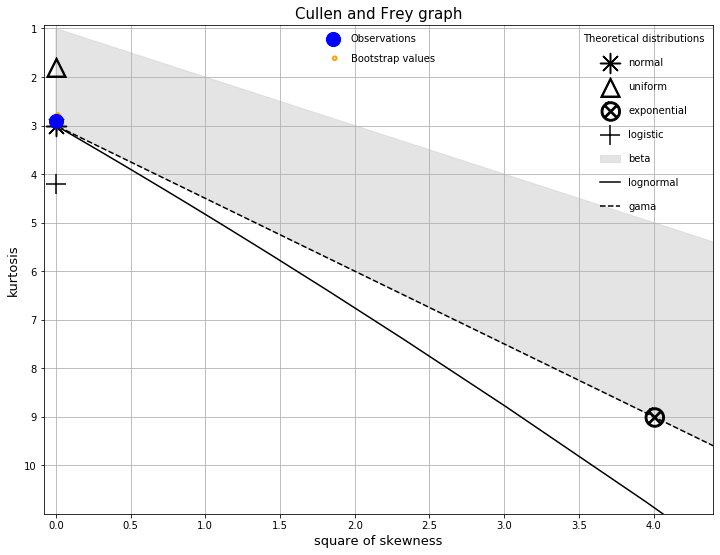

=== summary statistics ===
min:0.0000
max:1.0000
mean:0.5050
standard deviation:0.1357
skewness:-0.0086
kurtosis:-0.0872


Plotando o histograma do sinal beta:0 iter:0 ...


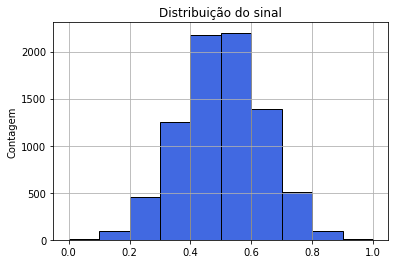



Deseja que o código encontre o melhor ajuste ou deseja ajustar uma gaussiana ou GEV?(1- Ajuste automático | 2- Gaussiana ou GEV): 2

Qual PDF deseja ajustar no histograma acima?(1- Para gaussiana| 2- Para GEV): 1

==== Parâmetros do ajuste com a gaussiana ====
Média: 0.5050
Desvio padrão: 0.1357


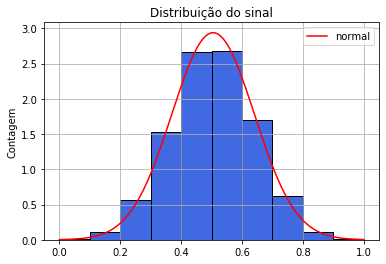

Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 1

Foram encontrados 60 sinais e 8192 entradas no arquivo sinais_0.csv:

beta:0 iter:0  |  beta:0 iter:1  |  beta:0 iter:2  |  beta:0 iter:3  |  beta:0 iter:4  |  beta:0 iter:5  |  beta:0 iter:6  |  beta:0 iter:7  |  beta:0 iter:8  |  beta:0 iter:9  |  beta:0 iter:10  |  beta:0 iter:11  |  beta:0 iter:12  |  beta:0 iter:13  |  beta:0 iter:14  |  beta:0 iter:15  |  beta:0 iter:16  |  beta:0 iter:17  |  beta:0 iter:18  |  beta:0 iter:19  |  beta:1 iter:0  |  beta:1 iter:1  |  beta:1 iter:2  |  beta:1 iter:3  |  beta:1 iter:4  |  beta:1 iter:5  |  beta:1 iter:6  |  beta:1 iter:7  |  beta:1 iter:8  |  beta:1 iter:9  |  beta:1 iter:10  |  beta:1 iter:11  |  beta:1 iter:12  |  beta:1 iter:13  |  beta:1 iter:14  |  beta:1 iter:15  |  beta:1 iter:16  |  beta:1 iter:17  |  beta:1 iter:18  |  beta:1 iter:19  |  beta:2 iter:0  |  beta:2 iter:1  |  beta:2 iter:2  |  beta:2 iter:3  |  beta:2 iter:4  |  beta:2 iter:5  |  beta:2 iter:6  

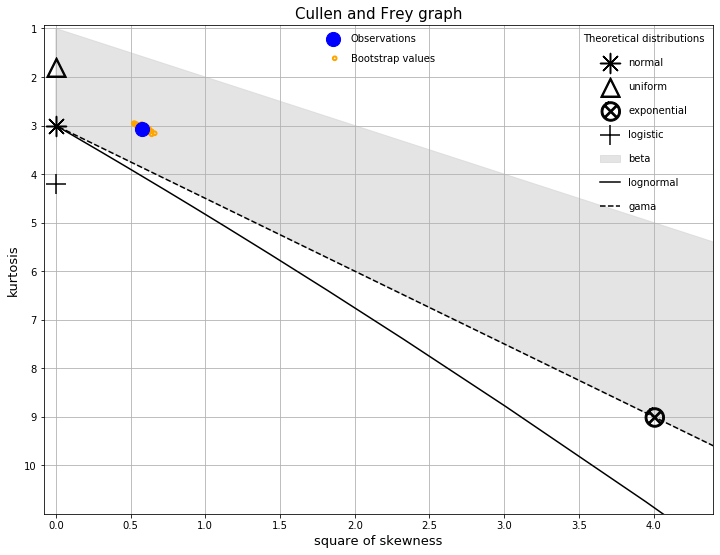

=== summary statistics ===
min:0.0000
max:1.0000
mean:0.3826
standard deviation:0.1909
skewness:0.7587
kurtosis:0.0653


Plotando o histograma do sinal beta:2 iter:13 ...


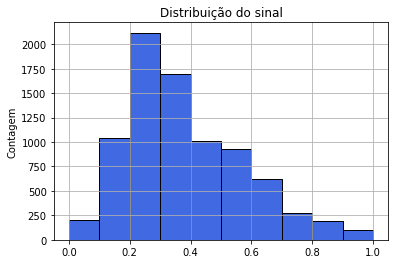



Deseja que o código encontre o melhor ajuste ou deseja ajustar uma gaussiana ou GEV?(1- Ajuste automático | 2- Gaussiana ou GEV): 2

Qual PDF deseja ajustar no histograma acima?(1- Para gaussiana| 2- Para GEV): 2

==== Parâmetros do ajuste com a GEV ====
Forma (c): -0.0011
Média: 0.2945
Desvio padrão: 0.1508


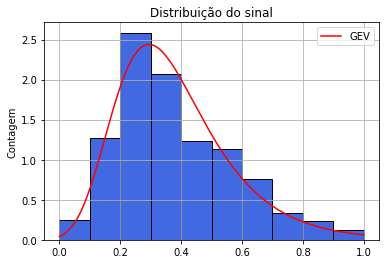

Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 4

Digite 0 ou 1 apenas!
Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): teste
Digite apenas 0 ou 1!
Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 0
Deseja abrir outro arquivo csv? (0- Não |1- Sim): 9

Digite 0 ou 1 apenas!
Deseja abrir outro sinal deste mesmo arquivo? (0- Não |1- Sim): 0
Deseja abrir outro arquivo csv? (0- Não |1- Sim): 0


In [35]:
# Como o algoritmo irá mostrar na tela os arquivos no diretório atual, nenhuma entrada é necessária
cullen_frey_graph = reader()